In [1]:
import sys
import os
_path = os.path.abspath('../scripts/')
if _path not in sys.path:
    sys.path.append(_path)

import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.special import logsumexp

from pyia import GaiaData
import theano
# theano.config.gcc.cxxflags = "-fbracket-depth=16000" # default is 256 - only need this on Mac??
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

from model import GroupHepler

In [2]:
run_name = '400pc-cube-result'
t = at.Table.read(f'../cache/probs-{run_name}.fits')
d = at.Table.read(f'../data/{run_name}.fits.gz')
joined = at.join(d, t, keys='source_id', join_type='left')

allg = GaiaData(joined)
g = allg[(allg.prob > 0.5) & (allg.get_ruwe() < 1.4)]

In [12]:
clean_gal = g.get_skycoord().galactic
clustered = ((clean_gal.cartesian.x < 50*u.pc) &
             (clean_gal.cartesian.x > -5*u.pc) &
             (clean_gal.cartesian.y > 0*u.pc) &
             (clean_gal.cartesian.y < 50*u.pc) &
             (clean_gal.cartesian.z > 30*u.pc) &
             (clean_gal.cartesian.z < 50*u.pc))
clean_mg = (g.phot_g_mean_mag - g.distmod)
da_best = g[clustered & (clean_mg < 8*u.mag)]

len(da_best)

16

In [61]:
da_best.data.write('../data/the-best-16.csv', overwrite=True)

### Take a 200 pc cube centered on this clump:

In [67]:
best_xyz = da_best.get_skycoord().galactic.cartesian.without_differentials()
best_xyz = best_xyz.mean()

In [75]:
all_xyz = allg.get_skycoord().galactic.cartesian.without_differentials()
og_200pc_cube_mask = np.all(np.abs((all_xyz - best_xyz).xyz) < 100*u.pc, 
                            axis=0)
og_200pc_cube_mask.sum()

311671

In [76]:
allg.data[og_200pc_cube_mask].write('../data/clump-200pc-cube.fits', overwrite=True)

### Run the Group model on the best members:

In [33]:
helper = GroupHelper(da_best)

In [34]:
model = helper.get_model()

In [35]:
with model:
    res = xo.optimize(start={'vxyz': helper.test_vxyz,
                             'r': helper.test_r})

optimizing logp for variables: [vxyz, lnsigv, meanv, r]


message: Optimization terminated successfully.
logp: -298.3778743599678 -> -193.75763448368247


In [37]:
res['sigv']

array([0.81452254, 0.45150807, 1.00414563])

In [38]:
res['meanv']

array([-6.13614299, 24.0605506 , -9.41418696])

In [39]:
with model:
    trace = pm.sample(start=res,
                      tune=2000,
                      draws=1000,
                      cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [vxyz, lnsigv, meanv, r]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 555 seconds.


In [48]:
names = ['x', 'y', 'z']

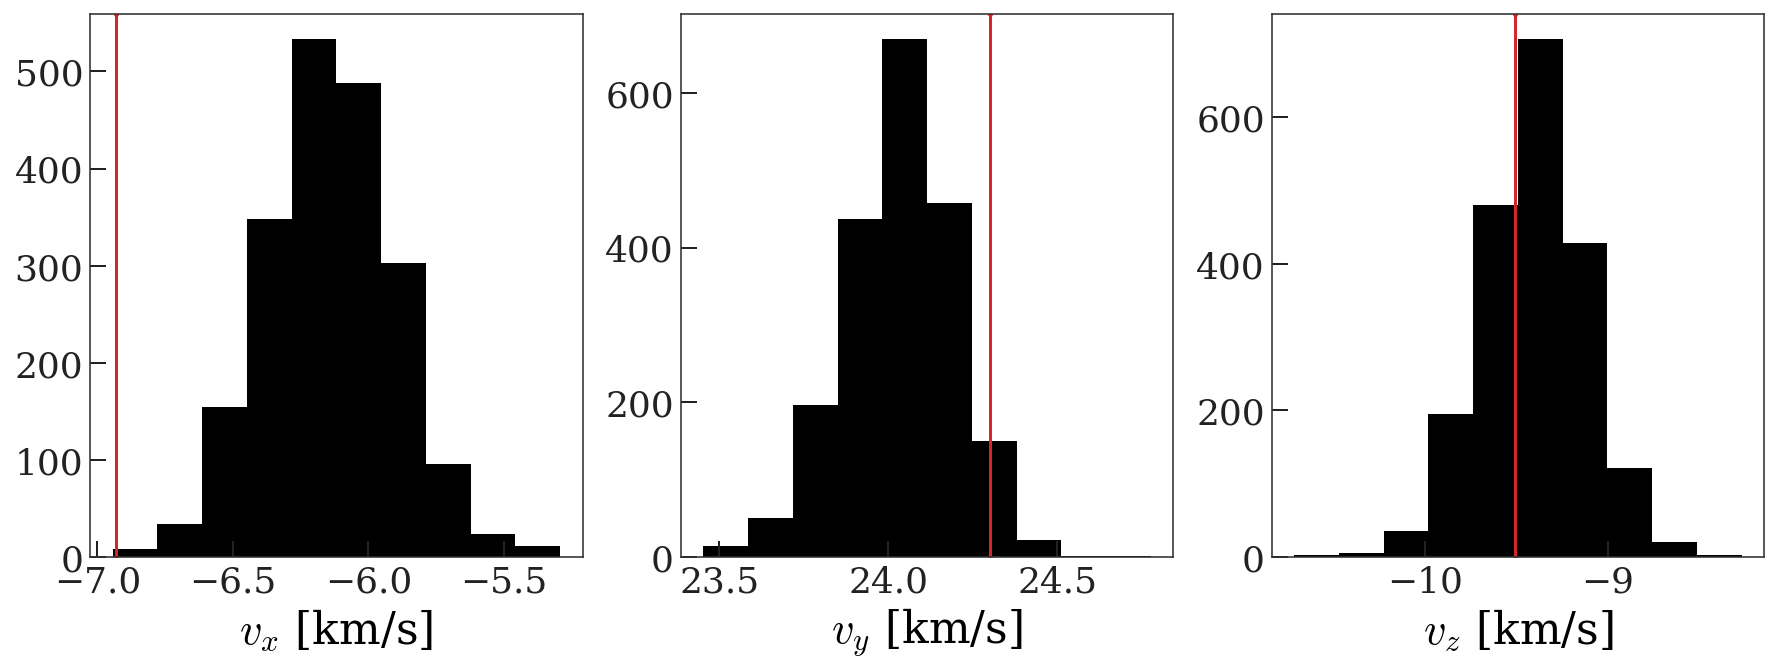

In [53]:
v0 = [-6.932, 24.301, -9.509]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.hist(trace['meanv'][:, i])
    ax.set_xlabel(f'$v_{names[i]}$ [km/s]')
    ax.axvline(v0[i], color='tab:red')

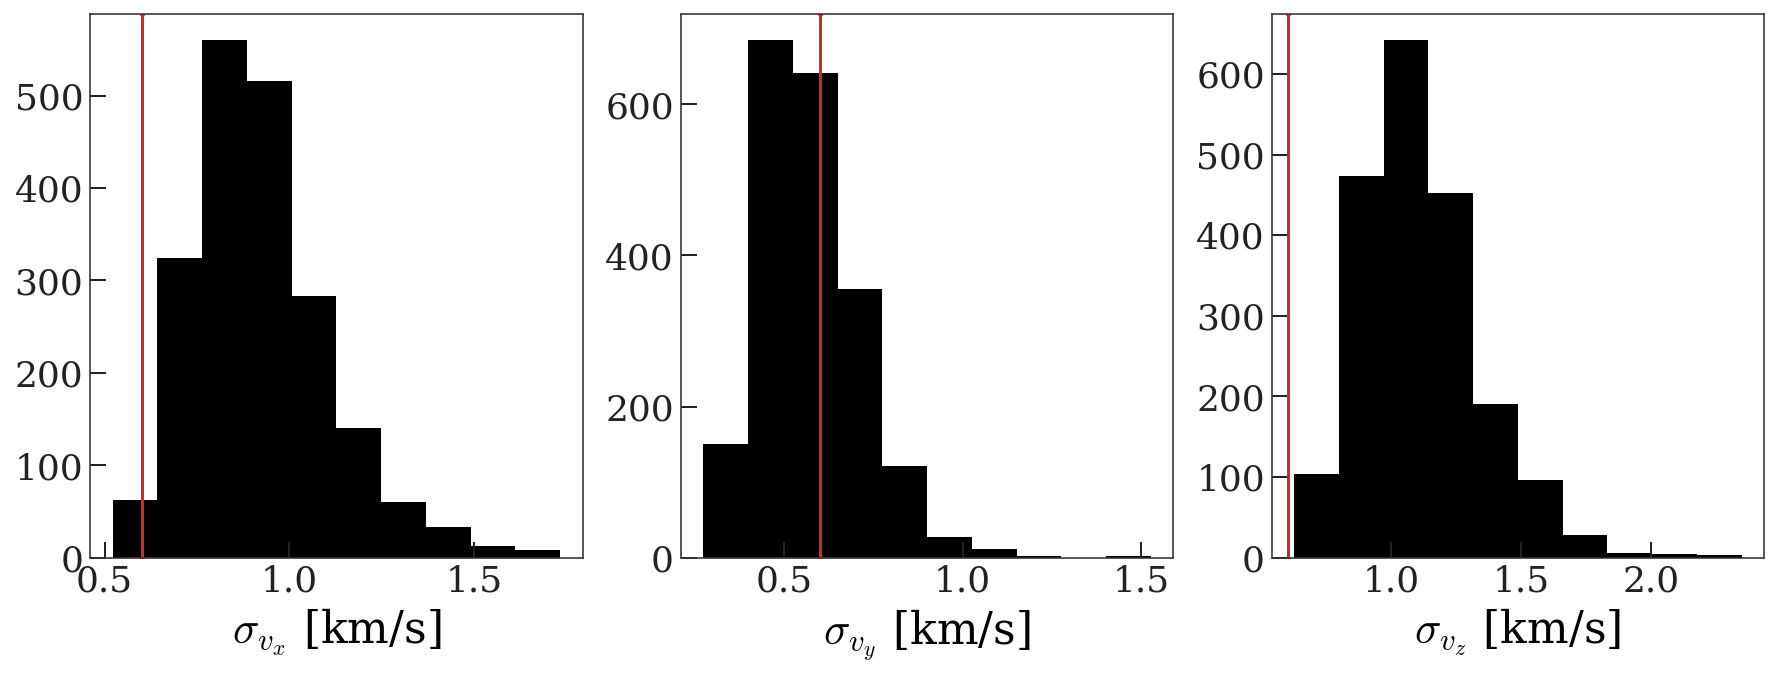

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.hist(trace['sigv'][:, i])
    ax.set_xlabel(f'$\sigma_{{v_{names[i]}}}$ [km/s]')
    ax.axvline(0.6, color='tab:red')

In [55]:
np.median(trace['meanv'], axis=0)

array([-6.14171028, 24.04023986, -9.39651267])

In [62]:
np.median(trace['sigv'], axis=0)

array([0.8947527 , 0.55371407, 1.08043307])